In [3]:
!pip install pyarrow scikeras tensorflow keras


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd

# Carregar o arquivo feather
df = pd.read_feather('Dados_Jan1980_mar2020_interpolado.feather')  

# Converter longitudes de 0–360 para -180–180
df['lon'] = df['lon'].apply(lambda x: x - 360 if x > 180 else x)

# Verificar valores mínimos e máximos para entender se conversão está ok
print(f"Longitude min: {df['lon'].min()}, max: {df['lon'].max()}")
print(f"Latitude min: {df['lat'].min()}, max: {df['lat'].max()}")

# Aplicar filtro para domínio Nordeste (lon e lat)
df_nordeste = df[
    (df['lon'] >= -46.5) & (df['lon'] <= -33.5) &
    (df['lat'] >= -19.1) & (df['lat'] <= -1.0)
]

print(f"Dados filtrados para Nordeste: {df_nordeste.shape[0]} linhas restantes")

# Analisar coluna t2m
target_col = "t2m"

if target_col not in df_nordeste.columns:
    raise ValueError(f"Coluna alvo '{target_col}' não encontrada. Colunas disponíveis: {df_nordeste.columns.tolist()} ")

print("Valores ausentes por coluna (top):")
print(df_nordeste.isna().sum().sort_values(ascending=False).head(10))
display(df_nordeste[[target_col]].describe().T)

Longitude min: -88.75, max: -31.25
Latitude min: -58.75, max: 8.75
Dados filtrados para Nordeste: 23184 linhas restantes
Valores ausentes por coluna (top):
year       0
month      0
lat        0
lon        0
temp850    0
press      0
shum850    0
t2m        0
u500       0
u850       0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
t2m,23184.0,24.652708,1.94606,16.6644,23.358475,24.94945,26.155625,30.0916


In [5]:
# t2m como target
# temperatura do ar medida a 2 metros de altura (padrão meteorológico para representar a temperatura próxima à superfície)

target_col = "t2m"

if target_col not in df_nordeste.columns:
    raise ValueError(f"Coluna alvo '{target_col}' não encontrada. Colunas disponíveis: {df_nordeste.columns.tolist()} ")

print("Valores ausentes por coluna (top):")
print(df_nordeste.isna().sum().sort_values(ascending=False).head(10))
display(df_nordeste[[target_col]].describe().T)

Valores ausentes por coluna (top):
year       0
month      0
lat        0
lon        0
temp850    0
press      0
shum850    0
t2m        0
u500       0
u850       0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
t2m,23184.0,24.652708,1.94606,16.6644,23.358475,24.94945,26.155625,30.0916



Correlação (valor absoluto) do alvo com outras variáveis:


t2m        1.000000
lat        0.638502
u500      -0.607117
press      0.604432
u850      -0.404422
temp850    0.349165
lon        0.273792
v850       0.225592
year       0.108441
shum850    0.076122
month      0.021540
prgpcp     0.003987
Name: t2m, dtype: float64

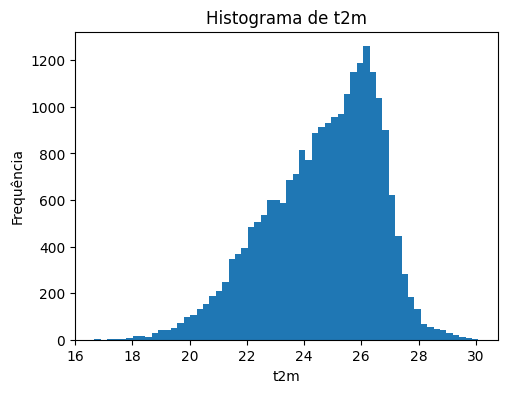

In [ ]:
# Distribuição da variável alvo (histograma + boxplot)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df_nordeste[target_col].dropna(), bins=60)
plt.title(f"Histograma de {target_col}")
plt.xlabel(target_col)
plt.ylabel("Frequência")




# Matriz de correlação (apenas numéricas) entre target e demais atributos

num_cols = df_nordeste.select_dtypes(include="number").columns.tolist()
if target_col not in num_cols:
    print("Alvo não é numérico — verifique.")
else:
    corr = df_nordeste[num_cols].corr()[target_col].sort_values(key=lambda x: x.abs(), ascending=False)
    print("\nCorrelação (valor absoluto) do alvo com outras variáveis:")
    display(corr.head(12))

In [ ]:
k = 5
corr_vals = df_nordeste[num_cols].corr()[target_col].abs().sort_values(ascending=False)
candidate_features = [c for c in corr_vals.index if c != target_col][:k]
print("Features candidatas selecionadas automaticamente:", candidate_features)

#X e y, e remove linhas com NA nas colunas escolhidas
X = df_nordeste[candidate_features].copy()
y = df_nordeste[target_col].copy()
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)
print("Shape after drop NA:", X.shape, y.shape)

Features candidatas selecionadas automaticamente: ['lat', 'u500', 'press', 'u850', 'temp850']
Shape after drop NA: (23184, 5) (23184,)


In [9]:
# Ajuste o nome da coluna de tempo

time_col_candidates = [c for c in df_nordeste.columns if "date" in c.lower() or "data" in c.lower() or "time" in c.lower()]
print("Possíveis colunas de tempo:", time_col_candidates)

# Se existir uma coluna temporal, reconstituir X e y ordenados; se não, assumimos que os dados já estão em ordem temporal.
time_col = time_col_candidates[0] if time_col_candidates else None
if time_col:
    df_tmp = df_nordeste.loc[mask].sort_values(time_col).reset_index(drop=True)
    X = df_tmp[candidate_features]
    y = df_tmp[target_col]
    print("ordenado por", time_col)
else:
    print("Nenhuma coluna temporal detectada automaticamente. Verifique se os dados já estão ordenados.")

Possíveis colunas de tempo: []
Nenhuma coluna temporal detectada automaticamente. Verifique se os dados já estão ordenados.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from tensorflow.keras import layers

# Função que constrói o modelo
def build_model(n_hidden=1, n_neurons=32, activation="tanh", dropout_rate=0.0, learning_rate=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))
    for _ in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation="linear"))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

# Pipeline com scaler e regressor Keras
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KerasRegressor(model=build_model, verbose=0))
])

# Grid de hiperparâmetros 
param_grid = {
    "model__model__n_hidden": [6, 10],
    "model__model__n_neurons": [40, 50],
    "model__model__activation": ["tanh", "relu"],
    "model__model__dropout_rate": [0.0, 0.2],
    "model__model__learning_rate": [1e-3, 1e-4],
    "model__batch_size": [32, 64],
    "model__epochs": [10],
}

# TimeSeriesSplit interno para GridSearchCV
tscv_inner = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv_inner,
    scoring="neg_mean_squared_error", #GridSearchCV vai procurar a maior pontuação pois assume que “quanto maior, melhor” para a métrica (que equivale ao menor MSE).
    n_jobs=1,
    verbose=2
)


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# TimeSeriesSplit externo (nested CV)
tscv_outer = TimeSeriesSplit(n_splits=5)

outer_scores = []
fold_idx = 0

for train_idx, test_idx in tscv_outer.split(X):
    fold_idx += 1
    print(f"\n--- Fold externo {fold_idx} ---")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ajustar GridSearch no treino do fold externo
    grid.fit(X_train, y_train)

    print("Melhores parâmetros (grid interno):", grid.best_params_)
    print("Best CV score (neg MSE):", grid.best_score_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mse_fold = np.mean((y_test - y_pred) ** 2)
    mae_fold = np.mean(np.abs(y_test - y_pred))
    print(f"Fold {fold_idx} — MSE: {mse_fold:.4f}, MAE: {mae_fold:.4f}")

    outer_scores.append({"fold": fold_idx, "mse": mse_fold, "mae": mae_fold})

results_outer = pd.DataFrame(outer_scores)
print("\nResumo nested CV:")
display(results_outer)
print(f"MSE médio: {results_outer['mse'].mean():.4f}, MAE médio: {results_outer['mae'].mean():.4f}")



--- Fold externo 1 ---
Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END model__batch_size=32, model__epochs=10, model__model__activation=tanh, model__model__dropout_rate=0.0, model__model__learning_rate=0.001, model__model__n_hidden=6, model__model__n_neurons=40; total time=   1.9s
[CV] END model__batch_size=32, model__epochs=10, model__model__activation=tanh, model__model__dropout_rate=0.0, model__model__learning_rate=0.001, model__model__n_hidden=6, model__model__n_neurons=40; total time=   1.9s
[CV] END model__batch_size=32, model__epochs=10, model__model__activation=tanh, model__model__dropout_rate=0.0, model__model__learning_rate=0.001, model__model__n_hidden=6, model__model__n_neurons=40; total time=   2.0s
[CV] END model__batch_size=32, model__epochs=10, model__model__activation=tanh, model__model__dropout_rate=0.0, model__model__learning_rate=0.001, model__model__n_hidden=6, model__model__n_neurons=50; total time=   1.6s
[CV] END model__batch_size=32, mod

,fold,mse,mae
0,1,0.326709,0.448536
1,2,0.412061,0.483542
2,3,0.575625,0.608507
3,4,0.428188,0.503424
4,5,1.050846,0.873007


MSE médio: 0.5587, MAE médio: 0.5834


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Extrai melhores parâmetros do grid, com prefixo correto
best_params = grid.best_params_
print("Melhores parâmetros finais (último grid executado):", best_params)

# extraindo os parâmetros do modelo
model_kwargs = {
    "n_hidden": best_params.get("model__model__n_hidden", 1),
    "n_neurons": best_params.get("model__model__n_neurons", 32),
    "activation": best_params.get("model__model__activation", "tanh"),
    "dropout_rate": best_params.get("model__model__dropout_rate", 0.0),
    "learning_rate": best_params.get("model__model__learning_rate", 1e-3),
}

# Normaliza os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

final_model = build_model(**model_kwargs)

# Treina o modelo final com os melhores parâmetros de batch_size e epochs
final_model.fit(
    X_scaled,
    y,
    epochs=best_params.get("model__epochs", 10),       # cuidado: com prefixo
    batch_size=best_params.get("model__batch_size", 32),
    verbose=1
)

# previsões no conjunto completo
y_pred_all = final_model.predict(X_scaled).ravel()

# Calcula métricas
mse_final = mean_squared_error(y, y_pred_all)
mae_final = mean_absolute_error(y, y_pred_all)
print(f"MSE final (treino completo): {mse_final:.4f}")
print(f"MAE final (treino completo): {mae_final:.4f}")


Melhores parâmetros finais (último grid executado): {'model__batch_size': 32, 'model__epochs': 10, 'model__model__activation': 'relu', 'model__model__dropout_rate': 0.0, 'model__model__learning_rate': 0.001, 'model__model__n_hidden': 10, 'model__model__n_neurons': 40}
Epoch 1/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 29.5917 - mae: 2.4646 
Epoch 2/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4834 - mae: 0.5430
Epoch 3/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4443 - mae: 0.5184
Epoch 4/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4187 - mae: 0.5022
Epoch 5/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4279 - mae: 0.5099
Epoch 6/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4303 - mae: 0.5093
Epoch 7/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4342 - mae: 0.5117
Epoch 8/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4035 - mae: 0.4937
Epoch 9/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4149 - mae: 0.5006


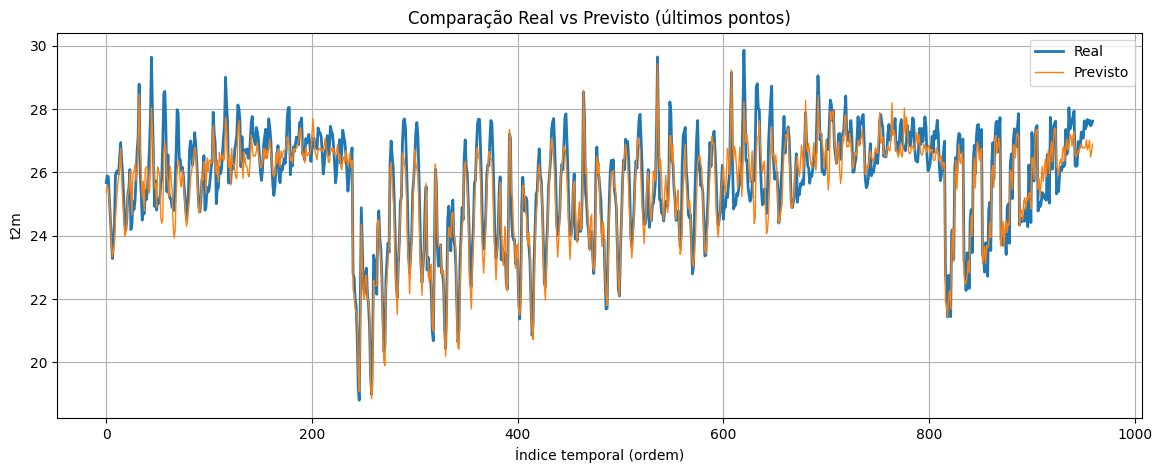

In [ ]:
# real x previsto
N = 960 #80 anos
plt.figure(figsize=(14,5))
plt.plot(y.values[-N:], label="Real", linewidth=2)
plt.plot(y_pred_all[-N:], label="Previsto", linewidth=1)
plt.title("Comparação Real vs Previsto (últimos pontos)")
plt.xlabel("Índice temporal (ordem)")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()